# Multi-label classification of research papers based on their abstract

The goal of this project is to classify arxiv papers into one of seven categories, based on their abstract. I used arxiv scraper ([link](https://github.com/Mahdisadjadi/arxivscraper)) to scrape the month worth of data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('C:\insight_program\\abstracts\TrainingData.csv')
df.head()

,Unnamed: 0,id,title,categories,abstract,doi,created,updated,authors
0,0,0803.2570,unequal error protection: an information theor...,cs.it cs.dm math.co math.it,an information theoretic framework for unequal...,10.1109/tit.2009.2032819,2008-03-18,2009-10-25,"['borade', 'nakiboglu', 'zheng']"
1,1,0808.0084,on the hitting times of quantum versus random ...,quant-ph cs.ds,in this paper we define new monte carlo type c...,NaN,2008-08-01,NaN,"['magniez', 'nayak', 'richter', 'santha']"
2,2,0812.2709,variations on a theme by schalkwijk and kailath,cs.it math.it,schalkwijk and kailath (1966) developed a clas...,10.1109/tit.2009.2034896,2008-12-14,2009-11-20,"['gallager', 'nakiboglu']"
3,3,0903.0197,rotation distance is fixed-parameter tractable,cs.ds,rotation distance between trees measures the n...,NaN,2009-03-01,NaN,"['cleary', 'john']"
4,4,0903.0199,a linear-time approximation algorithm for rota...,cs.ds,rotation distance between rooted binary trees ...,NaN,2009-03-01,2009-07-07,"['cleary', 'john']"


## 2. Data exploration

We are going to explore the data set a bit. Instead of working with bunch of sub-categories, at this point, we are going to identify 7 main categories to work with: computer science (cs), economics (econ), electrical engineering and systems science (eess), matemathics (math), physics (physics), quantitative biology (q-bio), quantitative finance (q-fin) and statistics (stat).

In [3]:
#add number of tags column
print(df['categories'][0])
df['categories'] = df['categories'].str.split()
df['number_of_tags'] = df['categories'].apply(len)
#how many abstracts with 1,2,3... tags
max_tags = df['number_of_tags'].max()
print(max_tags)
abs_per_tag = [len(df[df['number_of_tags']== (x+1)]) for x in range(max_tags)]
print(abs_per_tag)

cs.it cs.dm math.co math.it
7
[6957, 4382, 2140, 826, 298, 73, 12]


Let's look just at the main categories (ignoring sub-categories) for now. Function "main_categories" extracts main categories from tags.

In [4]:
def main_categories(tags):
    # Function that converts given tags to a list of main categories
    #test = ['cs.it', 'cs.dm', 'math.co', 'math.it']
    main_tags = [i.split(".") for i in tags if i]
    categories = [item[0] for item in main_tags]
    categories = list(set(categories))
    return categories

Scraper for some reason tags physics in a different way, only with subcategory instead of physics.subcategory, so here is the code to correct that.

In [7]:
physics_categories = ['astro-ph', 'cond-mat', 'gr-qc', 'hep-ex', 'hep-lat', 'hep-ph', 'hep-th', 'math-ph', 'nlin',
                      'nucl-ex', 'nucl-th', 'physics', 'quant-ph']

def physics_tags(tags):
    #Function that correct all physics sub-categories to 'physics'
    #tags = ['cs', 'math', 'quant-ph']
    result = ['physics' if item in physics_categories else item for item in tags]
    return list(set(result))

In [8]:
df['main_categories'] = df['categories'].apply(main_categories)
df['main_categories'] = df['main_categories'].apply(physics_tags)
df['number_of_categories'] = df['main_categories'].apply(len)

We determined the number of abstract labeled by 1, 2, 3... categories. Most abstracts are labeled with a single category, only some with 2 categories.

In [9]:
max_cat = df['number_of_categories'].max()
#how many abstracts with 1,2,3... tags
abs_no_categ = [len(df[df['number_of_categories'] == x+1]) for x in range(max_cat)]
print(abs_no_categ)

[10420, 3544, 672, 52]


Next step is to transform output categories from strings to sparse matrix of 0s and 1s using One-Hot encoding format.

In [12]:
allCategories = []
for n in df.main_categories:
    allCategories.extend(n)
    allCategories = list(set(allCategories))

category_to_id = dict([(j,i) for i, j in enumerate(allCategories)])
def OneHotEncoder(tags):
    vec = [0] * len(allCategories)
    for tag in tags:
        vec[category_to_id[tag]]=1
    return vec

y_df = df['main_categories'].apply(OneHotEncoder)

## 3. Text preprocessing

We are going to remove stop words and do the lemmatization. Text is allready lowercase and I'm leaving numbers for now, as we have math, pyhisics, statistics as categories...

In [14]:
#ABSTRACT TEXT PROCESSING
from nltk.corpus import stopwords
stopWordList = stopwords.words('english')

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import ToktokTokenizer

lemma = WordNetLemmatizer()
token = ToktokTokenizer()

def removeSpecialChars(text):
    str = '`-=~@#$%^&*()_+[!{;”:\’><.,/?”}]'
    for w in text:
        if w in str:
            text = text.replace(w,'')
    return text

def lemitizeWords(text):
    words = token.tokenize(text)
    listLemma =[]
    for w in words:
        x = lemma.lemmatize(w,'v')
        listLemma.append(x)
    text = " ".join(listLemma)
    return text

def stopWordsRemove(text):
    wordList = [x.strip() for x in token.tokenize(text)]
    removedList = [x for x in wordList if not x in stopWordList]
    text =" ".join(removedList)
    return text

def preprocessingText(text):
    text = removeSpecialChars(text)
    text = lemitizeWords(text)
    text = stopWordsRemove(text)
    return text

df['abstract'] = df['abstract'].map(lambda x: preprocessingText(x))

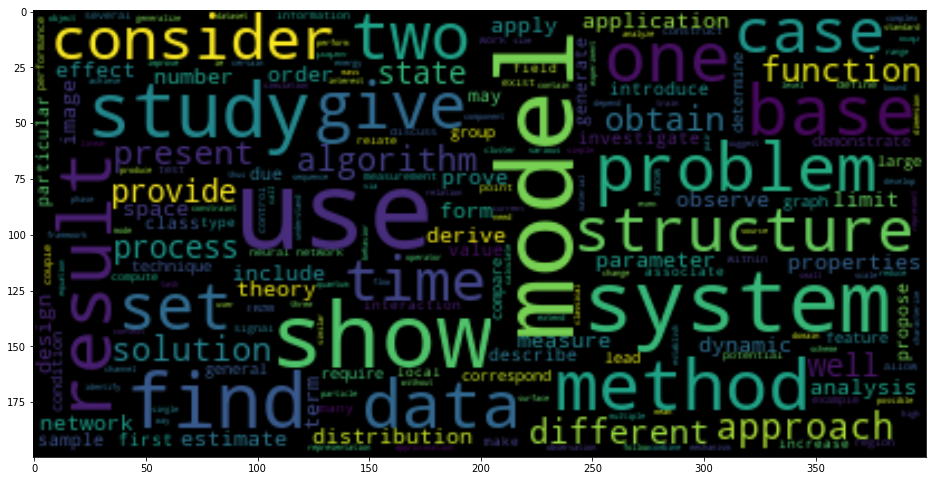

In [15]:
totalText = ''
for x in df.abstract:
    totalText = totalText + ' ' + x
    
from wordcloud import WordCloud
wc = WordCloud(background_color='black',max_font_size=50).generate(totalText)
plt.figure(figsize=(16, 12))
plt.imshow(wc, interpolation="bilinear")

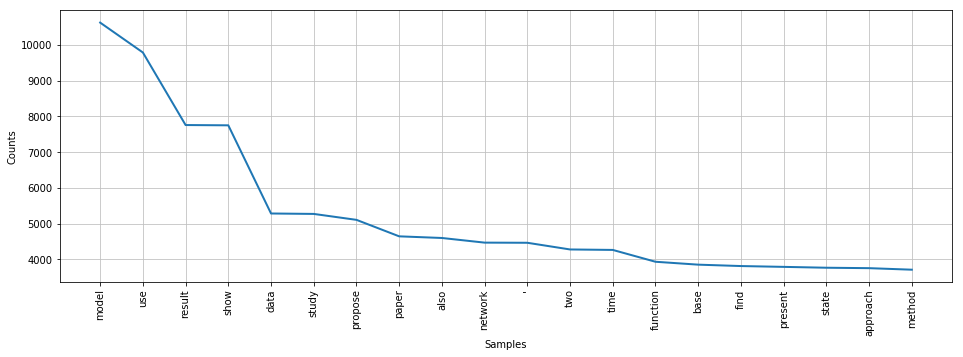

In [16]:
#frequency of the words
import nltk
from nltk.tokenize import ToktokTokenizer

x = nltk.FreqDist(ToktokTokenizer().tokenize(totalText))
plt.figure(figsize=(16,5))
x.plot(20)

## 4. Text classification

Now we can build our classifier. Since this is a multi-category data, we'll start by using Binary Relevance.

In [13]:
x1 = df['title'].values
x2 = df['abstract'].values
y = y_df.values
x1 = x1[0:5000]
x2 = x2[0:5000]
y = y[0:5000]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cvTitle = CountVectorizer().fit(x1)
title = pd.DataFrame(cvTitle.transform(x1).todense(), columns=cvTitle.get_feature_names())

cvAbstract = CountVectorizer().fit(x2)
abstract = pd.DataFrame(cvAbstract.transform(x2).todense(), columns=cvAbstract.get_feature_names())

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidftitle = TfidfTransformer().fit(title)
tit = pd.DataFrame(tfidftitle.transform(title).todense())

tfidfabs = TfidfTransformer().fit(abstract)
abst = pd.DataFrame(tfidfabs.transform(abstract).todense())

x = pd.concat([tit,abst], axis=1)

In [ ]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(x, y)
classifier = BinaryRelevance(GaussianNB())
classifier.fit(xtrain, ytrain)

In [ ]:
predictions = classifier.predict(xtest.astype(float))
predictions.toarray()

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(ytest[:,0], predictions[:,0])

In [ ]:
for i in range(len(allCategories)):
    print(accuracy_score(ytest[:,i], predictions[:,i]))